In [1]:
"""In this notebook, I am calculating the Coulomb repulsion energy as a function of the seperation distance between 
the remaining holes after photoionization of a positive trion. 
I use the wavefunction ansatz that has previously been used for the Helium atom. 
By transforming from the coordinates r1 and r2, which are the distances of the two holes from the electron,
I rewrote the wavefunction in terms of the hole-hole separation and the distance from CoM of the holes to the electron 
using the coordinates r_12 (the distance between the two holes) and R=r1+r2.

First, attempt is made for an analytical solution. I got something reasonable for the Coulomb potential, 
but something is wrong with the Keldysh potential. Still working on that.

Second, I use Monte Carlo methods to sample |Psi|^2 and calculate the distribution of potential energies from the sampled position of the holes.

Zach Withers
Stony Brook University
Nov. 22nd, 2025"""

'In this notebook, I am calculating the Coulomb repulsion energy as a function of the seperation distance between \nthe remaining holes after photoionization of a positive trion. \nI use the wavefunction ansatz that has previously been used for the Helium atom. \nBy transforming from the coordinates r1 and r2, which are the distances of the two holes from the electron,\nI rewrote the wavefunction in terms of the hole-hole separation and the distance from CoM of the holes to the electron \nusing the coordinates r_12 (the distance between the two holes) and R=r1+r2.\n\nFirst, attempt is made for an analytical solution. I got something reasonable for the Coulomb potential, \nbut something is wrong with the Keldysh potential. Still working on that.\n\nSecond, I use Monte Carlo methods to sample |Psi|^2 and calculate the distribution of potential energies from the sampled position of the holes.\n\nZach Withers\nStony Brook University\nNov. 22nd, 2025'

In [2]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from scipy import special

# pip install emcee
import emcee # MCMC sampler
import scipy.stats as stats

In [3]:
a = 10.3 # angstroms, radius of inner 1s shell
b = 25.2 # angstroms, radius of outer 1s shell

q_e = 1.6*10**-19 # electron charge
ep0 = 8.85*10**-12 # permittivity of free space, SI units
k = q_e**2/(4*np.pi*ep0*15) # J*m , multiplying by 1/15 to account for the in-plane dielectric constant of the TMDs, Laturia et al. npj 2D Materials and Applications (2018) 2:6
print(k)
a0 = 0.529 # angstroms, Bohr radius

# prefactor = k * (2/((np.pi*a*b)**2)) # don't convert a and b to meters here. It will cancel out when I multiply by the integrals which are in angstroms.
# the prefactor above is for the Coulomb potential
# the prefactor below is for the 2D Keldysh potential
rho0 = (7)*15/(2) # screening length in angstroms, 7 angstroms thickness of monolayer times 15 for in-plane dielectric constant, 
# divided by 2 due to screening length formula, BERKELBACH, HYBERTSEN, ANDREICHMAN, PRB 88, 045318 (2013), eqn 3
prefactor_keldysh = (2*np.pi*1**2)/((np.pi*a*b)**2 * 2 * (rho0/a0)) 
# ^^^ don't convert a and b since they will cancel with the integrals in angstroms, also using q_e=1 for atomic units here. The final result will have units of Hartrees

print(prefactor_keldysh)


1.5346013345207238e-29
4.760701645397441e-08


In [4]:
# analytical solution

r12_vec = np.linspace(3,200,101) # angstroms

# for each separation, r12, calculate the values of the integrals term by term, sum them up, and append to the result list
result = []
for r12 in r12_vec:

    #first term
    f = lambda R, theta: R* np.exp(-(1/a)*np.sqrt(r12**2+R**2+2*r12*R*np.cos(theta)))* np.exp(-(1/b)*np.sqrt(r12**2+R**2-2*r12*R*np.cos(theta)))
    #second term
    f2 = lambda R, theta: R* np.exp(-(1/b)*np.sqrt(r12**2+R**2+2*r12*R*np.cos(theta)))* np.exp(-(1/a)*np.sqrt(r12**2+R**2-2*r12*R*np.cos(theta)))
    #third term
    f3 = lambda R, theta: R* 2*np.exp(-(1/2)*((1/a)+(1/b))*np.sqrt(r12**2+R**2+2*r12*R*np.cos(theta)))* np.exp(-(1/2)*((1/a)+(1/b))*np.sqrt(r12**2+R**2-2*r12*R*np.cos(theta)))

    term1 = integrate.dblquad(f,0,1000000,0,2*np.pi) # these are in units of angstroms^4 to cancel out the angstroms^-4 in the prefactor
    term2 = integrate.dblquad(f2,0,1000000,0,2*np.pi)
    term3 = integrate.dblquad(f3,0,1000000,0,2*np.pi)

    H0 = special.struve(0, r12/rho0) # Struve function value
    Y0 = special.yn(0, r12/rho0) # Bessel function of the second kind value

    res = prefactor_keldysh*(H0 - Y0)*(term1[0] + term2[0] + term3[0]) # E_Coulomb(r12_i) in SI units
    result.append(res*27.2114) # convert from Hartrees to eV


/global/homes/j/jywu/.conda/envs/deep-gwbse/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [5]:
# # plot the integrand to check if it is well behaved
# # the integrand is really just |psi|^2, so I'd hope that it is well behaved

# R_vec = np.linspace(0,1000,1000)
# theta_vec = np.linspace(0,2*np.pi,200)
# r12 = b
# f_contour = []
# for R in R_vec:
#     for theta in theta_vec:
#         f_contour.append(f(R, theta)+f2(R, theta)+f3(R, theta))
# f_contour = np.array(f_contour).reshape(len(R_vec), len(theta_vec))

# plt.contourf(theta_vec, R_vec, f_contour, levels=50)
# # plt.colorbar(label='Integrand Value')
# plt.xlabel('Theta (radians)')
# plt.ylabel('R (angstroms)')
# plt.title('Integrand Contour Plot for r12 = {} angstroms'.format(r12))
# plt.show()

# # plot a line cut of the integrand at theta = 0
# f_linecut = f_contour[:,0]
# f_linecut2 = f_contour[:,20]
# plt.plot(R_vec, f_linecut)
# plt.plot(R_vec, f_linecut2,'r--')
# plt.vlines([a,b],0,5,'k','--')
# plt.xlabel('R (angstroms)')
# plt.ylabel('Integrand Value')
# plt.title('Integrand Line Cut at Theta = 0 for r12 = {} angstroms'.format(r12))
# plt.show()

# # plot a line cut of the integrand at R = b angstroms
# f_linecut_Rb = f_contour[ np.abs(R_vec - b).argmin(), : ]
# f_linecut_nearRb = f_contour[ np.abs(R_vec - (b+2)).argmin(), : ]
# plt.plot(theta_vec, f_linecut_Rb)
# plt.plot(theta_vec, f_linecut_nearRb,'r--')
# plt.xlabel('Theta (radians)')
# plt.ylabel('Integrand Value')
# plt.title('Integrand Line Cut at R = {} angstroms for r12 = {} angstroms'.format(b, r12))
# plt.show()


<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_590044/161145595.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Hole-Hole Separation ($\AA$)")
/tmp/ipykernel_590044/161145595.py:9: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Hole-Hole Separation ($\AA$)")
/tmp/ipykernel_590044/161145595.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Hole-Hole Separation ($\AA$)")
/tmp/ipykernel_590044/161145595.py:9: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Hole-Hole Separation ($\AA$)")


ValueError: x and y must have same first dimension, but have shapes (101,) and (93,)

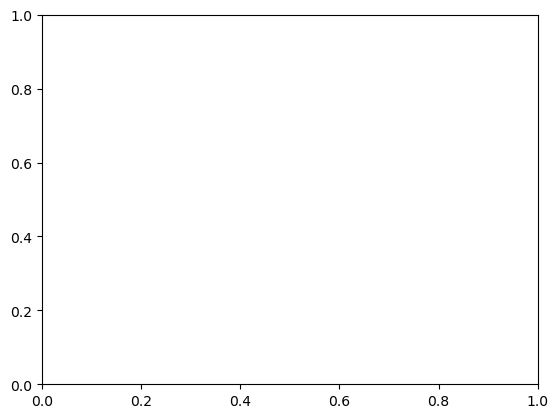

In [6]:
# plot the result
plt.plot(r12_vec,np.array(result))
plt.xlabel("Hole-Hole Separation ($\AA$)")
plt.ylabel("Energy (eV)")
plt.grid(True,'both')
plt.show()

plt.semilogy(r12_vec,np.array(result))
plt.xlabel("Hole-Hole Separation ($\AA$)")
plt.ylabel("Energy (eV)")
plt.grid(True,'both')
plt.show()

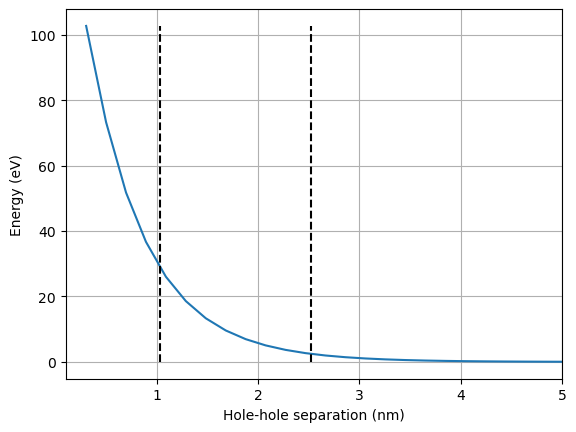

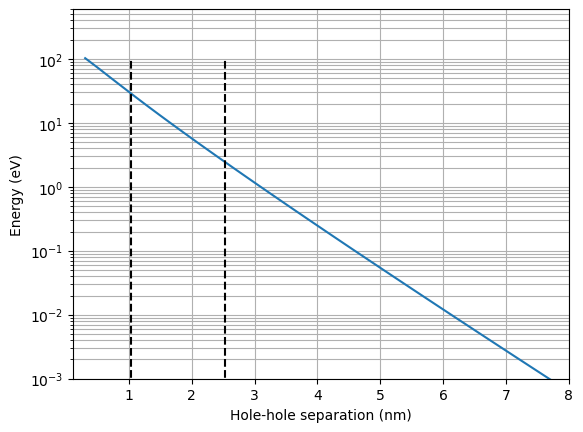

In [6]:
# zoom in around r12 = a,b

plt.plot(r12_vec/10,np.array(result))
plt.xlim(1/10, 50/10)
plt.xlabel("Hole-hole separation (nm)")
plt.ylabel("Energy (eV)")
plt.grid(True,'both')
plt.vlines([10.3/10, 25.2/10],0,np.max(np.array(result)),'k','--')
plt.show()

plt.semilogy(r12_vec/10,np.array(result))
plt.xlim(0.1, 8)
plt.ylim(10**-3,600)
plt.xlabel("Hole-hole separation (nm)")
plt.ylabel("Energy (eV)")
plt.grid(True,'both')
plt.vlines([10.3/10, 25.2/10],0,np.max(np.array(result)),'k','--')
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [02:56<00:00, 1133.34it/s]


(5000000, 4)


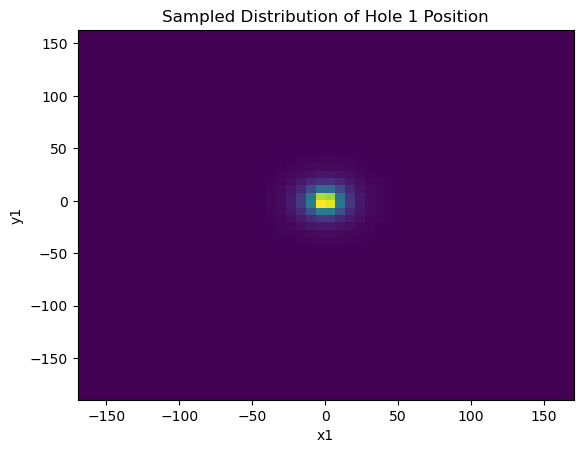

Mean acceptance fraction: 0.597
Mean autocorrelation time: 50.585 steps


In [7]:
############################################################################################

# Method #2: Use Monte Carlo algorithm to sample |\psi|^2 and then calculate the Coulomb energy for each sample.  

def psi1s(x, y, a):
    r = np.sqrt(x**2 + y**2)
    return (np.sqrt(2/(np.pi*a**2))) * np.exp(-r/a)

def psi_trion(x1, y1, x2, y2, a, b):
    return (1/np.sqrt(2))*(psi1s(x1, y1, a)*psi1s(x2, y2, b) + psi1s(x1, y1, b)*psi1s(x2, y2, a))

def prob_density(x1, y1, x2, y2, a, b):
    psi = psi_trion(x1, y1, x2, y2, a, b)
    return np.abs(psi)**2

# emcee requires the log of the probability density function
def log_pdf(x):
    return np.log(prob_density(x[0], x[1], x[2], x[3], a, b))

ndim = 4
nwalkers = 25
p0 = np.random.randn(nwalkers, ndim)  # initial positions of the walkers

sampler_burnin = emcee.EnsembleSampler(nwalkers, ndim, log_pdf)
# in general it is good to run some "burn-in" steps first so that the walkers effectively forget their initial positions
sampler_burnin.run_mcmc(p0, 10000, progress=True)
state = sampler_burnin.get_last_sample()
p0 = None
p0 = state.coords  # use the final positions of the 'burn-in' run as the starting positions for the main run

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_pdf)
num_steps = 200000
sampler.run_mcmc(p0, num_steps, progress=True)

samples = sampler.get_chain(flat=True)
print(samples.shape)  # should be (nwalkers * nsteps, ndim)
plt.hist2d(samples[:,0], samples[:,1], bins=50, density=True)
plt.xlabel('x1')
plt.ylabel('y1')
plt.title('Sampled Distribution of Hole 1 Position')
plt.show()

print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

# # Now, calculate the Coulomb repulsion energy for each sample
# coulomb_energies = []
# for sample in samples:
#     x1, y1, x2, y2 = sample
#     r12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) * 1e-10  # convert angstroms to meters
#     energy = k / r12  # Coulomb energy in Joules
#     coulomb_energies.append(energy)

# coulomb_energies = np.array(coulomb_energies)
# # Convert energies to eV
# coulomb_energies_ev = coulomb_energies / q_e # eV

# we aren't using the Coulomb potential, but instead a 2d screened potential

def struve_derivative(nu, x):
    return special.struve(nu - 1, x) - (nu / x) * special.struve(nu, x)

def calc_potential_E_from_samples(samples):
    # now we're going to work in atomic units for this particular calculation
    coulomb_energies = []
    rho0 = (7/a0)*15/(2) # 7 angstroms thickness of monolayer times 15 for in-plane dielectric constant, 
    # divided by 2 due to screening length formula, BERKELBACH, HYBERTSEN, ANDREICHMAN, PRB 88, 045318 (2013), eqn 3
    for sample in samples:
        x1, y1, x2, y2 = sample # units of angstroms
        r12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) / a0  # convert to atomic units
        H0 = special.struve(0, r12/rho0) # Struve function value
        Y0 = special.yvp(0, r12/rho0, 0) # Bessel function of the second kind value
        energy = np.pi*1**2/(2*rho0)*(H0 - Y0)  # Coulomb energy in Hartrees
        coulomb_energies.append(energy)

    coulomb_energies = np.array(coulomb_energies)
    coulomb_energies_ev = coulomb_energies * 27.2114  # Convert Hartrees to eV

    # calculations for comparing to the varial theorem
    V_prime_times_r12_list = []
    for sample in samples:
        x1, y1, x2, y2 = sample # units of angstroms
        r12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) / a0  # convert to atomic units
        H0_prime = struve_derivative(0, r12/rho0) # Struve function derivative value, for nu=0 its just H_-1
        Y0_prime = special.yvp(0, r12/rho0, 1) # Bessel function of the second kind, first derivative value
        V_prime_times_r12 = (np.pi*1**2/(2*rho0))*(H0_prime - Y0_prime)*(r12/rho0) * 27.2114
        V_prime_times_r12_list.append(V_prime_times_r12)

    return coulomb_energies_ev, V_prime_times_r12_list

coulomb_energies_ev, V_prime_times_r12_list = calc_potential_E_from_samples(samples)

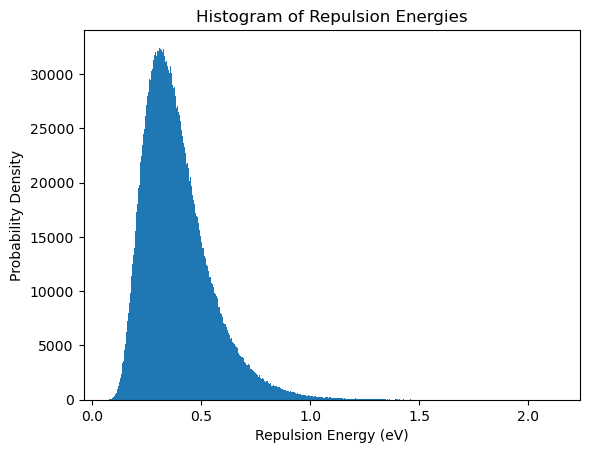

Fitted Lognormal shape:  0.38361498706288377
Fitted Lognormal loc:  0
Fitted Lognormal scale:  0.3631531353543317
Fitted Lognormal Mean:  0.39088165242023143  eV
Fitted Lognormal Variance:  0.024223059817617684  eV^2
Fitted Lognormal Std Dev:  0.1556375912741446  eV


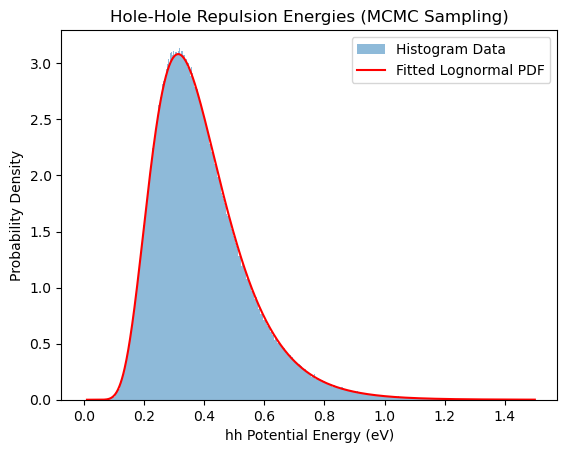

Mean from histogram data, <V>:  0.39105959454077277  eV
Estimated FWHM from histogram data:  0.29  eV


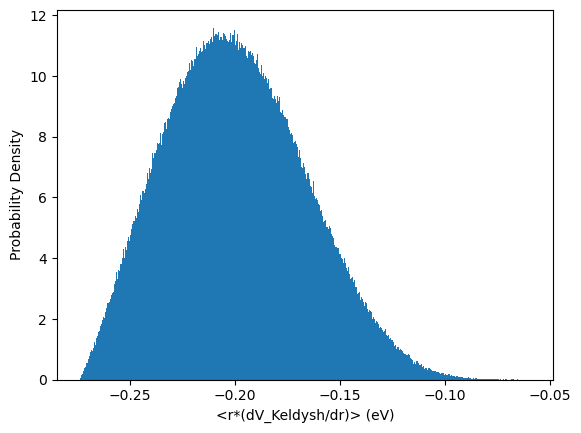

Mean from histogram data, <r*dV/dr>:  -0.19939676696741815  eV
According to the virial theorem, for a 2D Keldysh potential, <T> = (1/2)*<r*(dV/dr)>
and -E_binding = <T> + <V> = (1/2)*<r*(dV/dr)> + <V>: 0.2913612110570637  eV


In [8]:

# Plot histogram of Coulomb/keldysh potential energy, hole hole repulsion energies
plt.hist(coulomb_energies_ev, bins=1000)
plt.xlabel('Repulsion Energy (eV)')
plt.ylabel('Probability Density')
plt.title('Histogram of Repulsion Energies')
plt.show()

# # plot histogram of Coulomb energies, zoomed in around 0 to 5 eV
# plt.hist(coulomb_energies_ev, bins=1000, range=(0,5), density=True)
# plt.xlabel('Coulomb Energy (eV)')
# plt.ylabel('Probability Density')
# plt.title('Histogram of Coulomb Repulsion Energies (0-5 eV)')
# plt.show()

# fit a lognormal distribution to the histogram data

shape, loc, scale = stats.lognorm.fit(coulomb_energies_ev, floc=0)
print("Fitted Lognormal shape: ", shape)
print("Fitted Lognormal loc: ", loc)
print("Fitted Lognormal scale: ", scale)
x = np.linspace(0.01, 1.5, 1000)
pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

# print the variance and mean from the fitted distribution
mean, var = stats.lognorm.stats(shape, loc, scale, moments='mv')
print("Fitted Lognormal Mean: ", mean, " eV")
print("Fitted Lognormal Variance: ", var, " eV^2")
print("Fitted Lognormal Std Dev: ", np.sqrt(var), " eV")

plt.hist(coulomb_energies_ev, bins=1000, range=(0,1.5), density=True, alpha=0.5, label='Histogram Data')
plt.plot(x, pdf_fitted, 'r-', label='Fitted Lognormal PDF')
plt.xlabel('hh Potential Energy (eV)')
plt.ylabel('Probability Density')
plt.title('Hole-Hole Repulsion Energies (MCMC Sampling)')
# plt.axvline(x=mean, color='k', linestyle='--', label='Mean: {:.3f} eV'.format(mean))
# plt.axvline(x=mean+np.sqrt(var), color='b', linestyle='--', label='Std Dev: {:.3f} eV'.format(np.sqrt(var)))
plt.legend()
plt.show()

print("Mean from histogram data, <V>: ", np.mean(coulomb_energies_ev), " eV")

# def xexp_func(x, a, b):
#     return a * x * np.exp(-x/b)

# # fit an x*exp(-x/b) function to the histogram data
# params, covariance = curve_fit(xexp_func, x, np.histogram(coulomb_energies_ev, bins=1000, range=(0,5), density=True)[0], p0=[1,1])
# plt.hist(coulomb_energies_ev, bins=1000, range=(0,5), density=True, alpha=0.5, label='Histogram Data')
# plt.plot(x, xexp_func(x, *params), 'g--', label='Fitted x*exp(-x/b) PDF')
# plt.xlabel('Coulomb Energy (eV)')
# plt.ylabel('Probability Density')
# plt.title('x*exp(-x/b) Fit to Coulomb Repulsion Energies')
# plt.legend()
# plt.show()

# estimate full width at half maximum (FWHM) from the histogram data
bin_counts, bin_edges = np.histogram(coulomb_energies_ev, bins=1000, range=(0,5), density=True)
half_max = np.max(bin_counts) / 2
# find the bin edges where the count crosses half max
indices = np.where(bin_counts >= half_max)[0]
fwhm = bin_edges[indices[-1]+1] - bin_edges[indices[0]]
print("Estimated FWHM from histogram data: ", fwhm, " eV")

# plot the histogram for the V_prime_times_r12_list and calculate the expectation value so that we can compare with the varial theorem
plt.hist(V_prime_times_r12_list, bins=1000, density=True, label='Histogram Data')
plt.xlabel("<r*(dV_Keldysh/dr)> (eV)")
plt.ylabel('Probability Density')
plt.show()

print("Mean from histogram data, <r*dV/dr>: ",np.mean(np.array(V_prime_times_r12_list))," eV")

# Comparison to the virial theorem:
print("According to the virial theorem, for a 2D Keldysh potential, <T> = (1/2)*<r*(dV/dr)>")
print("and -E_binding = <T> + <V> = (1/2)*<r*(dV/dr)> + <V>:", (1/2)*np.mean(np.array(V_prime_times_r12_list)) + np.mean(coulomb_energies_ev), " eV")

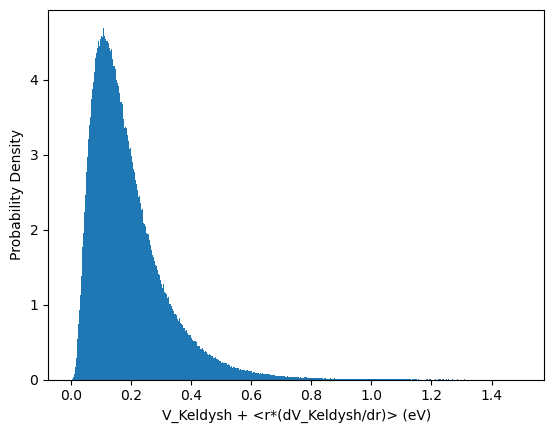

In [12]:
plt.hist(V_prime_times_r12_list + coulomb_energies_ev, bins=1000, density=True, label='Histogram Data', range=(0, 1.5))
plt.xlabel("V_Keldysh + <r*(dV_Keldysh/dr)> (eV)")
plt.ylabel('Probability Density')
plt.show()

In [11]:

################################################## do the same thing, but using the PDF from psi_1s only, model the exciton as a check
# this is modeling the exciton as a check
def prob_density_1s_Dani(x1, y1, a):
    # from K. Dani paper, Structure of the moiré exciton captured by imaging its electron and hole, SI page 8, no Moire
    psi = 1/(np.sqrt(2*np.pi)*a) * np.exp(-np.sqrt(x1**2 + y1**2)/(2*a))
    return np.abs(psi)**2

# emcee requires the log of the probability density function
def log_pdf_1s_only(x):
    radius = 17 # angstroms, from K. Dani paper, Structure of the moiré exciton captured by imaging its electron and hole, SI page 8, no Moire
    return np.log(prob_density_1s_Dani(x[0], x[1], radius))

ndim = 2
nwalkers = 20
p0 = np.random.randn(nwalkers, ndim)  # initial positions of the walkers
sampler_burnin_1s = emcee.EnsembleSampler(nwalkers, ndim, log_pdf_1s_only)
# in general it is good to run some "burn-in" steps first so that the walkers
sampler_burnin_1s.run_mcmc(p0, 10000, progress=True)
state = sampler_burnin_1s.get_last_sample()
p0 = None
p0 = state.coords  # use the final positions of the 'burn-in' run as the starting positions for the main run

sampler_1s = emcee.EnsembleSampler(nwalkers, ndim, log_pdf_1s_only)
num_steps = 200000
sampler_1s.run_mcmc(p0, num_steps, progress=True)
samples_1s = sampler_1s.get_chain(flat=True)
print(samples_1s.shape)  # should be (nwalkers * nsteps, ndim)
# Now, calculate the Coulomb repulsion energy for each sample
# coulomb_energies_rej_1sonly = []
# for sample in samples_1s:
#     x1, y1 = sample
#     r12 = np.sqrt((x1)**2 + (y1)**2) * 1e-10  # convert angstroms to meters
#     energy = k / (r12)  # Coulomb energy in Joules
#     coulomb_energies_rej_1sonly.append(energy)

def calc_potential_E_from_samplesExciton(samples):
    # now we're going to work in atomic units for this particular calculation
    coulomb_energies = []
    rho0 = (7/a0)*15/(2) # 7 angstroms thickness of monolayer times 15 for in-plane dielectric constant, 
    # divided by 2 due to screening length formula, BERKELBACH, HYBERTSEN, ANDREICHMAN, PRB 88, 045318 (2013), eqn 3
    for sample in samples:
        x1, y1 = sample # units of angstroms
        r12 = np.sqrt((x1)**2 + (y1)**2) / a0  # convert to atomic units
        H0 = special.struve(0, r12/rho0) # Struve function value
        Y0 = special.yn(0, r12/rho0) # Bessel function of the second kind value
        energy = -np.pi*1**2/(2*rho0)*(H0 - Y0)  # Coulomb energy in Hartrees, negative sign for attraction
        coulomb_energies.append(energy)

    coulomb_energies = np.array(coulomb_energies)
    coulomb_energies_ev = coulomb_energies * 27.2114  # Convert Hartrees to eV

    # calculations for comparing to the varial theorem
    V_prime_times_r12_list = []
    for sample in samples:
        x1, y1 = sample # units of angstroms
        r12 = np.sqrt((x1)**2 + (y1)**2) / a0  # convert to atomic units
        H0_prime = struve_derivative(0, r12/rho0) # Struve function derivative value, for nu=0 its just H_-1
        Y0_prime = special.yvp(0, r12/rho0, 1) # Bessel function of the second kind, first derivative value
        V_prime_times_r12 = -(np.pi*1**2/(2*rho0))*(H0_prime - Y0_prime)*(r12/rho0) * 27.2114 # negative sign for attraction
        V_prime_times_r12_list.append(V_prime_times_r12)

    return coulomb_energies_ev, V_prime_times_r12_list

coulomb_energies_exciton_1sonly_eV, V_prime_times_r12_list_1s_only = calc_potential_E_from_samplesExciton(samples_1s)


100%|██████████| 200000/200000 [01:35<00:00, 2093.57it/s]


(4000000, 2)


Mean Keldysh Energy (MCMC, Exciton):  0.3433781937286572  eV
Std Dev Keldysh Energy (MCMC, Exciton):  0.1616803090516835  eV
Mode Keldysh Energy (MCMC, Exciton):  0.24436174488468493  eV
Fitted Lognormal Mean (MCMC, Exciton):  0.34324094825388296  eV
Fitted Lognormal Variance (MCMC, Exciton):  0.026086940064650965  eV^2
Fitted Lognormal Std Dev (MCMC, Exciton):  0.16151451967130065  eV


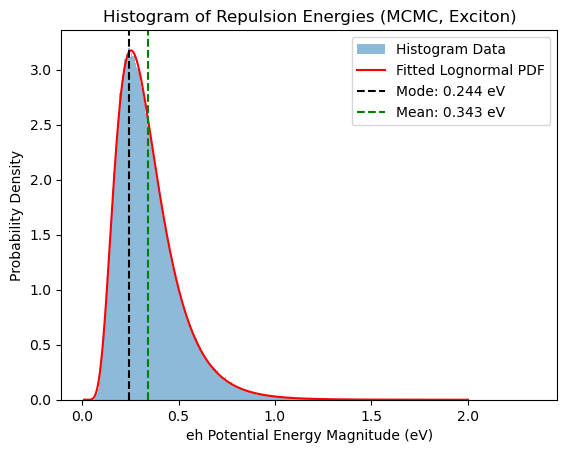

Estimated FWHM from histogram data:  0.275  eV
First Moment of Coulomb Energies (MCMC, Exciton):  0.343377935  eV


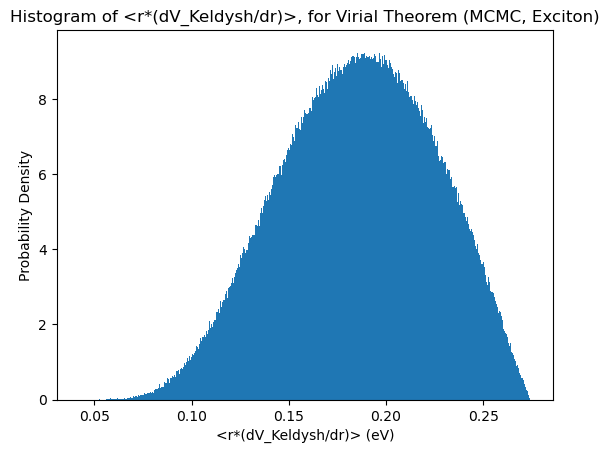

Mean from histogram data, <r*dV/dr> (MCMC, Exciton):  0.18521299341970435  eV
According to the virial theorem, for a 2D Keldysh potential, <T> = (1/2)*<r*(dV/dr)>
and -E_binding = <T> + <V> = (1/2)*<r*(dV/dr)> + <V>: -0.25077169701880503  eV


In [12]:
# this is terribly named, it is not rejection sampling, it is MCMC sampling of the exciton wavefunction
mean_energy_exciton = np.mean(-coulomb_energies_exciton_1sonly_eV)
std_energy_exciton = np.std(-coulomb_energies_exciton_1sonly_eV)
print("Mean Keldysh Energy (MCMC, Exciton): ", mean_energy_exciton, " eV")
print("Std Dev Keldysh Energy (MCMC, Exciton): ", std_energy_exciton, " eV")
# find the Keldysh energy with the highest probability density from the histogram data
bin_counts_exciton, bin_edges_exciton = np.histogram(-coulomb_energies_exciton_1sonly_eV, bins=1000, density=True)
max_index_exciton = np.argmax(bin_counts_exciton)
print("Mode Keldysh Energy (MCMC, Exciton): ", bin_edges_exciton[max_index_exciton], " eV")

# fit a lognormal distribution to the histogram data
shape_exciton, loc_exciton, scale_exciton = stats.lognorm.fit(-coulomb_energies_exciton_1sonly_eV, floc=0)
mean_exciton, var_exciton = stats.lognorm.stats(shape_exciton, loc_exciton, scale_exciton, moments='mv')
print("Fitted Lognormal Mean (MCMC, Exciton): ", mean_exciton, " eV")
print("Fitted Lognormal Variance (MCMC, Exciton): ", var_exciton, " eV^2")
print("Fitted Lognormal Std Dev (MCMC, Exciton): ", np.sqrt(var_exciton), " eV")
# Plot histogram of Coulomb energies
plt.hist(-coulomb_energies_exciton_1sonly_eV, bins=1000, density=True, alpha=0.5, label='Histogram Data')
x_exciton = np.linspace(0.01, 2, 1000)
pdf_fitted_exciton = stats.lognorm.pdf(x_exciton, shape_exciton, loc_exciton, scale_exciton)
plt.plot(x_exciton, pdf_fitted_exciton, 'r-', label='Fitted Lognormal PDF')
plt.xlabel('eh Potential Energy Magnitude (eV)')
plt.ylabel('Probability Density')
plt.title('Histogram of Repulsion Energies (MCMC, Exciton)')
plt.axvline(x=bin_edges_exciton[max_index_exciton], color='k', linestyle='--', label='Mode: {:.3f} eV'.format(bin_edges_exciton[max_index_exciton]))
plt.axvline(x=mean_energy_exciton, color='g', linestyle='--', label='Mean: {:.3f} eV'.format(mean_energy_exciton))
plt.legend()
plt.show()

# # plot histogram of Coulomb energies, zoomed in around 0 to 5 eV
# plt.hist(coulomb_energies_rej_1sonly_eV, bins=1000, range=(0,5), density=True)
# plt.xlabel('Coulomb Energy (eV)')
# plt.ylabel('Probability Density')
# plt.title('Histogram of Coulomb Repulsion Energies (MCMC, 1s only, 0-5 eV)')
# # vertical line at 0.3 eV
# plt.axvline(x=0.3, color='k', linestyle='--')
# plt.legend(['0.3 eV'])
# plt.show()

# estimate full width at half maximum (FWHM) from the histogram data
bin_counts, bin_edges = np.histogram(-coulomb_energies_exciton_1sonly_eV, bins=1000, range=(0,5), density=True)
half_max = np.max(bin_counts) / 2
# find the bin edges where the count crosses half max
indices = np.where(bin_counts >= half_max)[0]
fwhm = bin_edges[indices[-1]+1] - bin_edges[indices[0]]
print("Estimated FWHM from histogram data: ", fwhm, " eV")

# calculate the first moment of the coulomb energies from histogram data
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
first_moment = np.sum(bin_centers * bin_counts) / np.sum(bin_counts)
print("First Moment of Coulomb Energies (MCMC, Exciton): ", first_moment, " eV")

# histogram for the V_prime_times_r12_list_1s_only and calculate the expectation value so that we can compare with the varial theorem
plt.hist(V_prime_times_r12_list_1s_only, bins=1000, density=True, label='Histogram Data')
plt.xlabel("<r*(dV_Keldysh/dr)> (eV)")
plt.ylabel('Probability Density')
plt.title("Histogram of <r*(dV_Keldysh/dr)>, for Virial Theorem (MCMC, Exciton)")
plt.show()

print("Mean from histogram data, <r*dV/dr> (MCMC, Exciton): ",np.mean(np.array(V_prime_times_r12_list_1s_only))," eV")
# Comparison to the virial theorem:
print("According to the virial theorem, for a 2D Keldysh potential, <T> = (1/2)*<r*(dV/dr)>")
print("and -E_binding = <T> + <V> = (1/2)*<r*(dV/dr)> + <V>:",
      (1/2)*np.mean(np.array(V_prime_times_r12_list_1s_only)) + np.mean(coulomb_energies_exciton_1sonly_eV), " eV")


In [13]:
################

# Method 3: Rejection sampling

import numpy as np

# Sampling bounds for each dimension
bounds = [(-50, 50), (-50, 50), (-50, 50), (-50, 50)]

# Precompute maximum PDF value for rejection sampling
grid_points = 50
grid = np.array(np.meshgrid(
    *[np.linspace(lo, hi, grid_points) for lo, hi in bounds]
)).T.reshape(-1, 4)
pdf_vals = np.array([prob_density(pt[0], pt[1], pt[2], pt[3], a, b) for pt in grid])
pdf_max = pdf_vals.max()
print("Precomputed PDF max value for rejection sampling:", pdf_max) # if this is wrong, then the 2 sampling methods won't overlap

# Rejection sampling
def rejsample_from_pdf(n_samples):
    samples = []
    while len(samples) < n_samples:
        # Uniform proposal in bounds
        candidate = np.array([np.random.uniform(lo, hi) for lo, hi in bounds])
        # Accept/reject
        if np.random.rand() < prob_density(candidate[0], candidate[1], candidate[2], candidate[3], a, b) / pdf_max:
            samples.append(candidate)
    return np.array(samples)

# Draw samples
del(samples)
samples = rejsample_from_pdf(50000)
print("Shape of samples:", samples.shape)

# Now, calculate the Coulomb repulsion energy for each sample
# coulomb_energies_rej = []
# for sample in samples:
#     x1, y1, x2, y2 = sample
#     r12 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2) * 1e-10  # convert angstroms to meters
#     energy = k / r12  # Coulomb energy in Joules
#     coulomb_energies_rej.append(energy)
# coulomb_energies_rej = np.array(coulomb_energies_rej)
# # Convert energies to eV
# coulomb_energies_ev_rej = coulomb_energies_rej / q_e # eV

coulomb_energies_ev_rej, _  = calc_potential_E_from_samples(samples)


Precomputed PDF max value for rejection sampling: 8.107406537777162e-06


KeyboardInterrupt: 

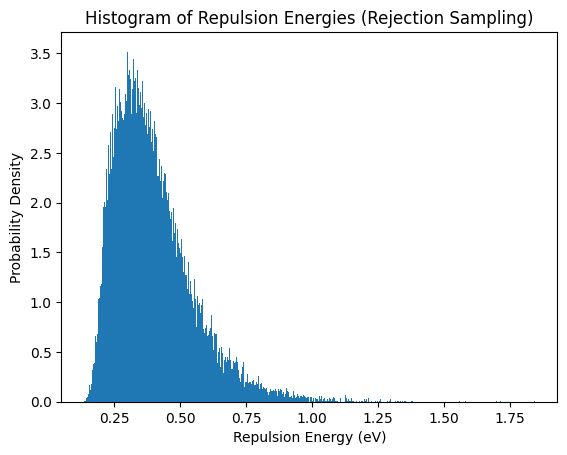

In [27]:

# Plot histogram of Repulsion energies
plt.hist(coulomb_energies_ev_rej, bins=1000, density=True)
plt.xlabel('Repulsion Energy (eV)')
plt.ylabel('Probability Density')
plt.title('Histogram of Repulsion Energies (Rejection Sampling)')
plt.show()

# plot histogram of Coulomb energies, zoomed in around 0 to 5 eV
# plt.hist(coulomb_energies_ev_rej, bins=1000, range=(0,5), density=True)
# plt.xlabel('Repulsion Energy (eV)')
# plt.ylabel('Probability Density')
# plt.title('Histogram of Repulsion Energies (0-5 eV, Rejection Sampling)')
# plt.show()


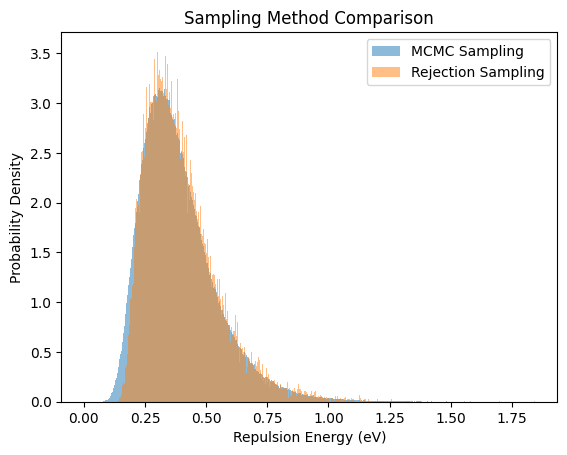

In [29]:
# plot the two histograms on the same plot for comparison
plt.hist(coulomb_energies_ev, bins=1000, range=(0,1.5), density=True, alpha=0.5, label='MCMC Sampling')
plt.hist(coulomb_energies_ev_rej, bins=1000, density=True, alpha=0.5, label='Rejection Sampling')
plt.xlabel('Repulsion Energy (eV)')
plt.ylabel('Probability Density')
plt.title('Sampling Method Comparison')
plt.legend()
plt.show()